In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import seaborn as sn
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.utils import resample

nlp = spacy.blank('id')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df['label'].value_counts()

negatif    1101
positif    1017
netral      997
Name: label, dtype: int64

In [5]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [6]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos_text, y_pos_label, test_size=0.2, random_state=1, stratify=y_pos_label)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_text, y_neg_label, test_size=0.2, random_state=1, stratify=y_neg_label)
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_net_text, y_net_label, test_size=0.2, random_state=1, stratify=y_net_label)

In [7]:
X_pos_train_down = resample(X_pos_train, replace=True, n_samples=int(len(X_net_train)))
y_pos_train_down = resample(y_pos_train, replace=True, n_samples=int(len(y_net_train)))

X_neg_train_down = resample(X_neg_train, replace=True, n_samples=int(len(X_net_train)))
y_neg_train_down = resample(y_neg_train, replace=True, n_samples=int(len(y_net_train)))

In [8]:
X_train = pd.concat([X_net_train, X_pos_train_down])
X_train = pd.concat([X_train, X_neg_train_down])
y_train = pd.concat([y_net_train, y_pos_train_down])
y_train = pd.concat([y_train, y_neg_train_down])

X_test = pd.concat([X_net_test, X_pos_test])
X_test = pd.concat([X_test, X_neg_test])
y_test = pd.concat([y_net_test, y_pos_test])
y_test = pd.concat([y_test, y_neg_test])

In [9]:
print(y_train.value_counts())

netral     797
positif    797
negatif    797
Name: label, dtype: int64


In [10]:
model = FastText.load('Model/XGBDownSampling.bin')

In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc = preprocessing.LabelEncoder()
lc.fit(y_train)

LabelEncoder()

In [14]:
y_train_enc = lc.transform(y_train)
y_test_enc = lc.transform(y_test)

In [15]:
train = xgb.DMatrix(X_train_vector,label=y_train_enc)
test = xgb.DMatrix(X_test_vector,label=y_test_enc)

In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

# Learning Rate:  0.01
# Gamma:  0.5
# Max Depth:  12
# Subsample:  0.4
# Colsample Bytree:  0.3
# Alpha:  0.01
# Lamda:  2
# Min Child Weight:  3
# Number of Trees:  1000


param['num_class']=len(set(y_train))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.5
param['max_depth'] = 12
param['subsample'] = 0.4
param['colsample_bytree'] = 0.3
param['reg_alpha'] = 0.01
param['reg_lambda'] = 2
param['min_child_weight'] = 3
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.33501	test-merror:0.59040
[1]	train-merror:0.23547	test-merror:0.54880
[2]	train-merror:0.18779	test-merror:0.52320
[3]	train-merror:0.15726	test-merror:0.53760
[4]	train-merror:0.14094	test-merror:0.52320
[5]	train-merror:0.11502	test-merror:0.49120
[6]	train-merror:0.10874	test-merror:0.48800
[7]	train-merror:0.10163	test-merror:0.49920
[8]	train-merror:0.08616	test-merror:0.50080
[9]	train-merror:0.07988	test-merror:0.49440
[10]	train-merror:0.07236	test-merror:0.48000
[11]	train-merror:0.06566	test-merror:0.48000
[12]	train-merror:0.05479	test-merror:0.48160
[13]	train-merror:0.05437	test-merror:0.49120
[14]	train-merror:0.05312	test-merror:0.49120
[15]	train-merror:0.05061	test-merror:0.48000
[16]	train-merror:0.05019	test-merror:0.47520
[17]	train-merror:0.04601	test-merror:0.48320
[18]	train-merror:0.04266	test-merror:0.48320
[19]	train-merror:0.04140	test-merror:0.46720
[20]	train-merror:0.04224	test-merror:0.47680
[21]	train-merror:0.03931	test-merror:0.4816

[177]	train-merror:0.00251	test-merror:0.46560
[178]	train-merror:0.00251	test-merror:0.46880
[179]	train-merror:0.00251	test-merror:0.47040
[180]	train-merror:0.00251	test-merror:0.46880
[181]	train-merror:0.00251	test-merror:0.46720
[182]	train-merror:0.00251	test-merror:0.46720
[183]	train-merror:0.00251	test-merror:0.46560
[184]	train-merror:0.00251	test-merror:0.46720
[185]	train-merror:0.00251	test-merror:0.46400
[186]	train-merror:0.00251	test-merror:0.46400
[187]	train-merror:0.00251	test-merror:0.46720
[188]	train-merror:0.00251	test-merror:0.46560
[189]	train-merror:0.00209	test-merror:0.46720
[190]	train-merror:0.00209	test-merror:0.46400
[191]	train-merror:0.00209	test-merror:0.46560
[192]	train-merror:0.00167	test-merror:0.47040
[193]	train-merror:0.00167	test-merror:0.47040
[194]	train-merror:0.00167	test-merror:0.47200
[195]	train-merror:0.00167	test-merror:0.47360
[196]	train-merror:0.00167	test-merror:0.47360
[197]	train-merror:0.00167	test-merror:0.47200
[198]	train-m

[352]	train-merror:0.00084	test-merror:0.47200
[353]	train-merror:0.00084	test-merror:0.47200
[354]	train-merror:0.00084	test-merror:0.47360
[355]	train-merror:0.00084	test-merror:0.46880
[356]	train-merror:0.00084	test-merror:0.47200
[357]	train-merror:0.00084	test-merror:0.47040
[358]	train-merror:0.00084	test-merror:0.47200
[359]	train-merror:0.00084	test-merror:0.47360
[360]	train-merror:0.00084	test-merror:0.47200
[361]	train-merror:0.00084	test-merror:0.47040
[362]	train-merror:0.00084	test-merror:0.46880
[363]	train-merror:0.00084	test-merror:0.47040
[364]	train-merror:0.00084	test-merror:0.47360
[365]	train-merror:0.00084	test-merror:0.47040
[366]	train-merror:0.00042	test-merror:0.47360
[367]	train-merror:0.00042	test-merror:0.47680
[368]	train-merror:0.00042	test-merror:0.47200
[369]	train-merror:0.00042	test-merror:0.47360
[370]	train-merror:0.00042	test-merror:0.47200
[371]	train-merror:0.00042	test-merror:0.47520
[372]	train-merror:0.00042	test-merror:0.47360
[373]	train-m

[527]	train-merror:0.00042	test-merror:0.47360
[528]	train-merror:0.00042	test-merror:0.47360
[529]	train-merror:0.00042	test-merror:0.47200
[530]	train-merror:0.00042	test-merror:0.47200
[531]	train-merror:0.00042	test-merror:0.47520
[532]	train-merror:0.00042	test-merror:0.47200
[533]	train-merror:0.00042	test-merror:0.47200
[534]	train-merror:0.00042	test-merror:0.46880
[535]	train-merror:0.00042	test-merror:0.47200
[536]	train-merror:0.00042	test-merror:0.47040
[537]	train-merror:0.00042	test-merror:0.47040
[538]	train-merror:0.00042	test-merror:0.47040
[539]	train-merror:0.00042	test-merror:0.46560
[540]	train-merror:0.00042	test-merror:0.46720
[541]	train-merror:0.00042	test-merror:0.46720
[542]	train-merror:0.00042	test-merror:0.46720
[543]	train-merror:0.00042	test-merror:0.46720
[544]	train-merror:0.00042	test-merror:0.46560
[545]	train-merror:0.00042	test-merror:0.46720
[546]	train-merror:0.00042	test-merror:0.46720
[547]	train-merror:0.00042	test-merror:0.46560
[548]	train-m

[702]	train-merror:0.00000	test-merror:0.47040
[703]	train-merror:0.00000	test-merror:0.46880
[704]	train-merror:0.00000	test-merror:0.47200
[705]	train-merror:0.00000	test-merror:0.47200
[706]	train-merror:0.00000	test-merror:0.47360
[707]	train-merror:0.00000	test-merror:0.47200
[708]	train-merror:0.00000	test-merror:0.47200
[709]	train-merror:0.00000	test-merror:0.47360
[710]	train-merror:0.00000	test-merror:0.47200
[711]	train-merror:0.00000	test-merror:0.47200
[712]	train-merror:0.00000	test-merror:0.47200
[713]	train-merror:0.00000	test-merror:0.47200
[714]	train-merror:0.00000	test-merror:0.47200
[715]	train-merror:0.00000	test-merror:0.47200
[716]	train-merror:0.00000	test-merror:0.47200
[717]	train-merror:0.00000	test-merror:0.47200
[718]	train-merror:0.00000	test-merror:0.47200
[719]	train-merror:0.00000	test-merror:0.47200
[720]	train-merror:0.00000	test-merror:0.47200
[721]	train-merror:0.00000	test-merror:0.47200
[722]	train-merror:0.00000	test-merror:0.47200
[723]	train-m

[877]	train-merror:0.00000	test-merror:0.47200
[878]	train-merror:0.00000	test-merror:0.47200
[879]	train-merror:0.00000	test-merror:0.47200
[880]	train-merror:0.00000	test-merror:0.47200
[881]	train-merror:0.00000	test-merror:0.47200
[882]	train-merror:0.00000	test-merror:0.47360
[883]	train-merror:0.00000	test-merror:0.47360
[884]	train-merror:0.00000	test-merror:0.47360
[885]	train-merror:0.00000	test-merror:0.47200
[886]	train-merror:0.00000	test-merror:0.47040
[887]	train-merror:0.00000	test-merror:0.47040
[888]	train-merror:0.00000	test-merror:0.47040
[889]	train-merror:0.00000	test-merror:0.47200
[890]	train-merror:0.00000	test-merror:0.47200
[891]	train-merror:0.00000	test-merror:0.47040
[892]	train-merror:0.00000	test-merror:0.47040
[893]	train-merror:0.00000	test-merror:0.47040
[894]	train-merror:0.00000	test-merror:0.47040
[895]	train-merror:0.00000	test-merror:0.47200
[896]	train-merror:0.00000	test-merror:0.47200
[897]	train-merror:0.00000	test-merror:0.47200
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.528 

Train Score
 1.0 

CONFUSSION MATRIX
 [[105  87  29]
 [ 38 135  27]
 [ 29  85  90]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.61      0.48      0.53       221
      netral       0.44      0.68      0.53       200
     positif       0.62      0.44      0.51       204

    accuracy                           0.53       625
   macro avg       0.56      0.53      0.53       625
weighted avg       0.56      0.53      0.53       625
 



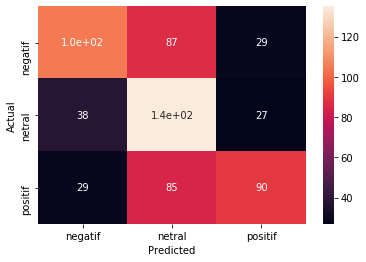

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])